In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

In [2]:
# preparing the data

DF = pd.read_excel('mibs_data.xlsx')
DF = DF.dropna(axis=1, how='all')
DF = DF.drop(columns = ['Start time', 'Completion time', 'Email', 'ID'])

DF.to_excel('mibs_ready.xlsx')

columns_to_be = ['uczelnia', 'kierunek', 'znajomosc','wazne_stanowiska',
                 'zwiazek_partnerski', 'zwiazek_malzenski', 'dzieci', 'nadmiernie', 'przemoc', 
                 'wydzwiek', 'kosciol', 'politycy', 'edukacja', 'zamieszkanie', 'płec']

DF.columns = columns_to_be

In [3]:
# changing values based on Likert scale

pozytywne = {'Zdecydowanie się zgadzam': 5, 'Raczej się zgadzam': 4, 'Nie mam zdania na ten temat': 3, 'Raczej się nie zgadzam': 2, 'Zdecydowanie się nie zgadzam': 1, 'Nie wiem / trudno powiedzieć': None}

negatywne = {'Zdecydowanie się zgadzam': 1, 'Raczej się zgadzam': 2, 'Nie mam zdania na ten temat': 3, 'Raczej się nie zgadzam': 4, 'Zdecydowanie się nie zgadzam': 5, 'Nie wiem / trudno powiedzieć': None}

pozytywne_kolumny = ['wazne_stanowiska', 'zwiazek_partnerski', 'zwiazek_malzenski', 'dzieci', 'przemoc', 
                     'wydzwiek', 'kosciol', 'politycy']

negatywne_kolumny = ['nadmiernie', 'edukacja']

kolumny = pozytywne_kolumny + negatywne_kolumny

DF[pozytywne_kolumny] = DF[pozytywne_kolumny].replace(pozytywne)
DF[negatywne_kolumny] = DF[negatywne_kolumny].replace(negatywne)

In [4]:
# unifying names of subjects respondents

DF['kierunek'] = DF['kierunek'].replace('[Ss][Oo][Cc]\w+', 'Socjologia', regex=True)
DF['kierunek'] = DF['kierunek'].replace('[Ff][Ii][Zz]\w+ \w+', 'Fizyka', regex=True)

In [5]:
# splitting dataframe into two dataframes based on the university of 

DF_UJ = DF[DF.uczelnia == 'UJ']
DF_AGH = DF[DF.uczelnia == 'AGH'] 
DF_obie = DF[DF.uczelnia == 'obie uczelnie (AGH i UJ) jednocześnie']
DF_UJ = DF_UJ.append(DF_obie)
DF_AGH = DF_AGH.append(DF_obie)

In [6]:
# calculating variance

DF.var()

wazne_stanowiska      0.394426
zwiazek_partnerski    0.448970
zwiazek_malzenski     1.411593
dzieci                1.933062
nadmiernie            1.490911
przemoc               0.900601
wydzwiek              0.845373
kosciol               0.934715
politycy              0.804295
edukacja              1.390545
dtype: float64

In [7]:
# calculating Cronbach's alpha "manually"

column_values = DF.corr().values.ravel()
corr_list = pd.unique(column_values)[1:]
alpha = 10*corr_list.mean() / (1+9*corr_list.mean())
alpha

0.8619463790996349

In [8]:
DF[pozytywne_kolumny+negatywne_kolumny] = DF[pozytywne_kolumny+negatywne_kolumny].astype(float)

In [9]:
# calculating Cronbach's alpha using a built-in function

pg.cronbach_alpha(data = DF[pozytywne_kolumny+negatywne_kolumny])

(0.8651719195942916, array([0.826, 0.898]))

In [10]:
DF['dzieci'].value_counts()

5.0    60
4.0    15
3.0    14
1.0    11
2.0     9
Name: dzieci, dtype: int64

In [11]:
# performing t-tests to check if dataframes are statistically different 

test = stats.ttest_ind(DF_AGH['dzieci'], DF_UJ['dzieci'], nan_policy = 'omit')
test

Ttest_indResult(statistic=-3.2158926240904586, pvalue=0.0017118083403349347)

In [12]:
test = stats.ttest_ind(DF_AGH['zwiazek_partnerski'], DF_UJ['zwiazek_partnerski'], nan_policy = 'omit')
test

Ttest_indResult(statistic=-1.2311903862078466, pvalue=0.22076363459568124)

In [13]:
test = stats.ttest_ind(DF_AGH.sum(axis=1), DF_UJ.sum(axis=1))
test

Ttest_indResult(statistic=-3.010781216243772, pvalue=0.0032037231493689303)

In [14]:
# saving ready file

DF.to_excel('gotowe.xlsx')

In [15]:
# preparing data for plotting

DF_AGH['suma'] = DF_AGH.sum(axis=1)
a = DF_AGH['suma'].value_counts()
a = dict(a)

DF_UJ['suma'] = DF_UJ.sum(axis=1)
b = DF_UJ['suma'].value_counts()
b = dict(b)

list_x1 = np.array([int(i) for i in a.keys()]) - 0.35/2
list_x2 = np.array([int(i) for i in b.keys()]) + 0.35/2
list_y1 = np.array([int(i) for i in a.values()]) 
list_y2 = np.array([int(i) for i in b.values()]) 

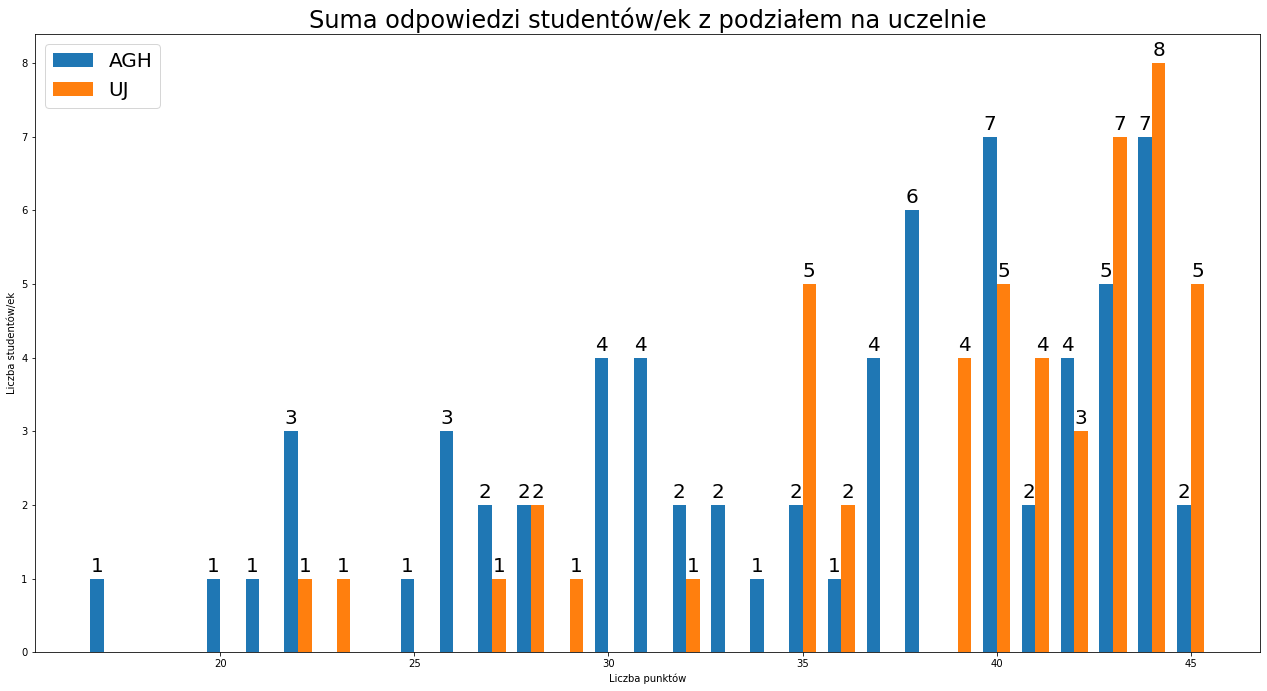

In [16]:
# plotting

fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 20})
fig.set_size_inches(18, 10)
width = 0.35
rects1 = ax.bar(list_x1, list_y1, width, label='AGH')
rects2 = ax.bar(list_x2, list_y2, width, label='UJ')
ax.set_xlabel('Liczba punktów')
ax.set_ylabel('Liczba studentów/ek')
ax.set_title('Suma odpowiedzi studentów/ek z podziałem na uczelnie')
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.savefig('suma.png', dpi=300)

In [17]:
# preparing data for plotting

DF_baby = DF[DF.płec == 'Kobieta']
DF_faceci = DF[DF.płec == 'Mężczyzna'] 
DF_faceci['suma'] = DF_faceci.sum(axis=1)
DF_baby['suma'] = DF_baby.sum(axis=1)
a = DF_faceci['suma'].value_counts()
b = DF_baby['suma'].value_counts()
a = dict(a)
b = dict(b)

list_x1 = np.array([int(i) for i in a.keys()]) - 0.35/2
list_x2 = np.array([int(i) for i in b.keys()]) + 0.35/2
list_y1 = np.array([int(i) for i in a.values()]) 
list_y2 = np.array([int(i) for i in b.values()]) 

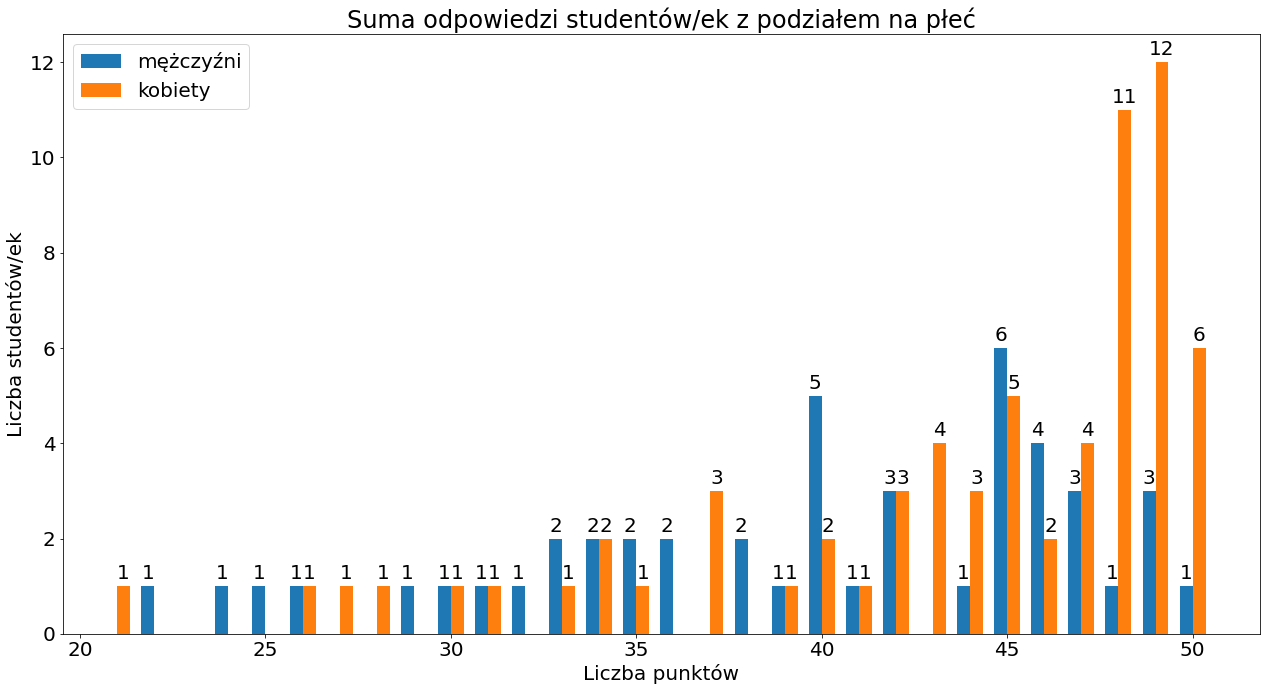

In [18]:
# plotting

fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 20})
fig.set_size_inches(18, 10)
width = 0.35
rects1 = ax.bar(list_x1, list_y1, width, label='mężczyźni')
rects2 = ax.bar(list_x2, list_y2, width, label='kobiety')
ax.set_xlabel('Liczba punktów')
ax.set_ylabel('Liczba studentów/ek')
ax.set_title('Suma odpowiedzi studentów/ek z podziałem na płeć')
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.savefig('plec.png', dpi=300)

In [19]:
# calculating variance of AGH dataframe

DF_AGH.var()

wazne_stanowiska       0.547264
zwiazek_partnerski     0.491180
zwiazek_malzenski      1.790067
dzieci                 2.279514
nadmiernie             1.459068
przemoc                1.206760
wydzwiek               0.899260
kosciol                1.124476
politycy               0.942212
edukacja               1.688811
suma                  54.601085
dtype: float64

In [20]:
# calculating variance of UJ dataframe

DF_UJ.var()

wazne_stanowiska       0.118197
zwiazek_partnerski     0.382041
zwiazek_malzenski      0.636525
dzieci                 1.115634
nadmiernie             1.291397
przemoc                0.541667
wydzwiek               0.931401
kosciol                0.989388
politycy               0.702449
edukacja               0.782041
suma                  35.020408
dtype: float64